<a href="https://colab.research.google.com/github/hirokiyokoyama/gan_workshop/blob/master/gan_workshop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 敵対的生成ネットワーク研究会
第一回のURL：
https://colab.research.google.com/drive/1egFCcIXzM7xtlXWRp9wFjDSocL5j94oP

第二回のURL：
https://colab.research.google.com/drive/1t_QRi-V77uqIvJIhqvtwUVYOcsKZmK_A

横山のgithub（こちらにもノートブックが置いてあります）
https://github.com/hirokiyokoyama/gan_workshop

## 本研究会の目的
機械学習のフィールドで一世を風靡したGANについて研究する。
 - 原理を理解する
 - 使ってみる
 - 学習してみる
 - 実装できるようになる
 - ビジネスへの応用について考えてみる
 - GANのアルゴリズムを発展させる（難関！）


 ## 本日の目的
 本日は、GANについては軽く触れる程度に留め、以下について実際にやってみながら勉強して行きます。

**GANに向かって行く一本筋の道のり**
 - Google Colaboratoryの使い方
 - TensorFlowの使い方（v2を見据えて…）
 - 機械学習の基礎
 - ニューラルネットワーク
 - 畳み込みニューラルネットワーク

In [0]:
# GPUを用いて高速に実行できる機械学習ライブラリ
import tensorflow as tf
tf.enable_eager_execution()

# 結果をプロットするためのライブラリ
import matplotlib.pyplot as plt

# GANとは何か？
- Generative Adversarial Networks（敵対的生成ネットワーク）
- 入力の生成過程をモデル化する（生成モデル）ニューラルネットワーク
- 教師なし学習（ラベル付きデータがいらない）

https://www.imagazine.co.jp/gan

In [0]:
#@title デモ用ファイルの準備
import os
if not os.path.exists('fashion_mnist_generator'):
  !wget -O fashion_mnist_generator.zip "https://drive.google.com/uc?export=download&id=1-9h71kdd7WLKPNqa-v4iU0xjGprdRSea"
  !unzip fashion_mnist_generator.zip && rm fashion_mnist_generator.zip
generator = tf.contrib.saved_model.load_keras_model('fashion_mnist_generator')

In [0]:
#@title GANの学習に使ったデータセット
#@markdown https://github.com/zalandoresearch/fashion-mnist
import tensorflow_datasets as tfds

# 画像を並べる数
rows = 5
cols = 10

ds = tfds.image.mnist.FashionMNIST()
ds.download_and_prepare()
dataset = ds.as_dataset()['train']
def preprocess(data):
  img = tf.cast(data['image'], tf.float32)/255.
  return tf.image.resize_bilinear([img], (32,32))[0], tf.one_hot(data['label'], 10)
dataset = dataset.map(preprocess)

for image, label in dataset.shuffle(1000).batch(rows*cols).take(1):
  image = image.numpy()
  if image.shape[3] == 1:
    image = image[:,:,:,0]

plt.figure(figsize=(12,5))

for i in range(rows):
  for j in range(cols):
    plt.subplot(rows, cols, i*cols+j+1)
    plt.imshow(image[i*cols+j], cmap='gray_r')
    plt.axis('off')
    plt.clim(0,1)

In [0]:
#@title GANが生成する画像を見てみる

import numpy as np

# 画像を並べる数
rows = 5
cols = 10

noise = tf.random_normal((rows*cols,)+generator.input_shape[1:])
image = generator(noise, training=False)

plt.figure(figsize=(12,5))

image = image.numpy()
if image.shape[3] == 1:
  image = image[:,:,:,0]
image = (image + 1.)/2.

for i in range(rows):
  for j in range(cols):
    plt.subplot(rows, cols, i*cols+j+1)
    plt.imshow(image[i*cols+j], cmap='gray_r')
    plt.axis('off')
    plt.clim(0,1)

In [0]:
#@title GANは与えられた数値を基に画像を生成する
n = 10

# 128次元ベクトルをランダムに二つ生成する
noise1 = tf.random_normal((1,)+generator.input_shape[1:])
noise2 = tf.random_normal((1,)+generator.input_shape[1:])

# 二つを内分する128次元ベクトルをn個生成する
p = tf.reshape(tf.linspace(0.,1.,n), [-1,1,1,1])
noise = (1-p)*noise1 + p*noise2

# 全てのベクトルから画像を生成する
image = generator(noise, training=False)
image = image.numpy()
if image.shape[3] == 1:
  image = image[:,:,:,0]
image = (image + 1.)/2.

# 各ベクトル（見やすいように最初の10次元だけ）と対応する画像を表示
plt.figure(figsize=(12,5))
for i in range(n):
  plt.subplot(2, n, i+1)
  noise_i = noise[i,0,0,:10].numpy()
  lim = max(abs(noise_i))
  plt.bar(range(10), noise_i)
  plt.ylim(-lim, lim)
  plt.axis('off')
  plt.subplot(2, n, n+i+1)
  plt.imshow(image[i], cmap='gray_r')
  plt.axis('off')
  plt.clim(0,1)

#TensorFlowによる数値計算

## スカラーの計算
- TensorFlowでは数値をtf.Tensorとして扱う。Python上の数値とは区別される。
- Tensorは数値型（dtype）を持っており、Python上の数値よりも明示的。
- TensorFlow上の定数であることを示すためにtf.constantを使用する。定数もtf.Tensorとして扱われる。
- Pythonの演算子を使ってtf.Tensor同士の演算を記述することができる。
- Tensor同士の演算結果もやはりtf.Tensorとして扱われる。

In [0]:
i = tf.constant(1)
print ('i =', i)

x = tf.constant(1.)
a = tf.constant(2.)
b = tf.constant(3, dtype=tf.float32)
c = tf.constant(4.)
y = a * x**2 + b * x + c
# 2 x 1^2 + 3 x 1 + 4 = 9
print('y =', y)

## テンソルの基本的な計算
- テンソルは基本的に数値の多次元配列であり、次元数をランクと呼ぶ。スカラーはランク0のテンソル。
- Pythonのリストを使ってテンソルを記述する。また、TensorFlowの関数を用いて様々なテンソルを表現できる。
- テンソルの要素はPythonの配列と同様に参照できる。
- テンソルの各次元のサイズはtf.shapeを使って取得する。Shape自体がランク1のTensorとなっている。
- テンソル同士の四則演算やテンソルのべき乗などは要素毎の演算となる。
- 要素毎の演算の際、片方のテンソルにおいてある次元が1の場合、ブロードキャストというルールが適用される。
- ランク2のテンソルを行列とみなして行列の積を計算できる（tf.matmul）。
- その他、特定の次元に沿って平均を求めたり（tf.reduce_mean）できる。
- Numpyを使ったことがある方は、TensorFlowにもほぼ同じ演算がほぼ同じインターフェースで用意されていると考えて頂いて結構です。

In [0]:
x = tf.constant([[1,2,3], [4,5,6]], dtype=tf.float32)
print('x =', x) # Pythonのリストで定数を記述
print('zeros =', tf.zeros([3,1])) # 全ての要素が0のテンソル
print('ones =', tf.ones([3,2])) # 全ての要素が1のテンソル
print('eye =', tf.eye(3)) # 3x3の単位行列
print('random =', tf.random.uniform([2,5])) # 各要素が0以上1未満の乱数となっているテンソル

print('x[0,1] =', x[0,1]) # 要素の参照
print('x[:,1] =', x[:,1]) # 列ベクトルの参照

y = tf.constant([[7.,8.,9.]])
print('y =', y)
x_plus_y = x + y # [2,3]と[1,3]なので足せる（最初の次元にブロードキャストが適用される）
print('x+y', x_plus_y) # この場合、[7,8,9]を最初の次元に沿ってコピーした[[7,8,9], [7,8,9]]をxに足すのと同じ

a = tf.constant([[1.,2.],[3.,4.]])
b = tf.constant([[5.,6.],[7.,8.]])
print('a * b =', a * b)
print('matmul(a, b) =', tf.matmul(a, b))

print('shape(x) =', tf.shape(x)) # 元のshapeは[2, 3]
z = tf.reduce_mean(x, 0) # 最初の次元に沿って平均を求める
print('z =', z) # [(1+4)/2, (2+5)/2, (3+6)/2]
print('shape(z) =', tf.shape(z)) # 最初の次元がなくなって結果のshapeは[3]

## 二次関数をプロットしてみる
- x軸を細かく分割して各々についてyを求める。
- パフォーマンスのためには、for文を使わずに、全てのxについての演算を一度に行う（重要）。

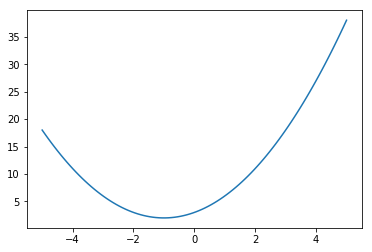

In [0]:
x = tf.linspace(-5., 5., 100) # -5から+5までを100等分した配列（[-5.0, -4.9, ..., 5.0]）
a = tf.constant(1.)
b = tf.constant(2.)
c = tf.constant(3.)
y = a * x**2 + b * x + c # a,b,cはスカラーだが、xの要素は100個あるのでブロードキャストされる

plt.plot(x, y) # matplotlibを用いてプロット

## 変数
- テンソルは、定数や演算結果を表すオブジェクトなので、値の変更はできない。一方で、変数は定義した後で値を変更できる。
- 変数はtf.Variableとして扱われる。演算としてはtf.Tensorと同様に扱える（結果はやはりtf.Tensor）。
- tf.get_variableで作ってassignなどのメソッドで値を代入する。普通に=を使って代入すると、tf.Variableが入っていたPython変数に別の値が代入されるだけ（Python上の普通の代入文）なので注意。

In [0]:
x = tf.get_variable('x', initializer=1.) # 名前と初期値を指定して変数を作る
print('x =', x)
x.assign(3.)
print('x =', x)
x.assign_add(0.5) # 現在の値に0.5を足したものを再び代入する
print('x =', x)

# shapeだけ指定すると初期値はランダムになる
y = tf.get_variable('y', [2,3])
print('y =', y.numpy()) # tf.Tensorもtf.Variableもnumpyメソッドで値だけ取り出せる
y.assign(tf.ones([2,3]))
print('y =', y.numpy())

#TensorFlowによる機械学習

## 勾配法（関数の最小化）
- 坂を下るように関数の値を小さくして行き、最小値（正確には極小値）を取る点を探す手法。
- 微分可能な関数に適用可能：関数が複雑で全貌がわからなくても、現在の点での傾きは求められることが多い。
- TensorFlowなどの機械学習ライブラリの多くは、微分を自動でやってくれる！

In [0]:
#@title 関数の定義
x = tf.get_variable('x', initializer=3.) # 初期値3の変数

# お馴染みの二次関数
def func(x):
  a = tf.constant(1.)
  b = tf.constant(2.)
  c = tf.constant(3.)
  return a * x**2 + b * x + c

# xの位置でグラフが右肩上がり（dx/dyが正）ならばxを小さく、左肩上がり（dx/dyが負）ならばxを大きくする。
# これを繰り返すとxはグラフの極小点に近づいて行く。
def update(x):
  with tf.GradientTape() as g: # GradientTapeのコンテキストの中で変数を使って計算すると
    y = func(x)
  dydx = g.gradient(y, x) # その変数による微分（dy/dx）を求めることができる
  x.assign_sub(dydx * 0.1) # 変数xからdy/dx * 0.1を引いたものを再びxに代入する

#グラフと現在のxをプロット
def plot(x):
  _x = tf.linspace(-5., 5., 100)
  _y = func(_x)
  plt.plot(_x, _y)
  y = func(x)
  plt.scatter(x.numpy(), y.numpy(), c='red')
  plt.text(x.numpy(), y.numpy(), 'x={}'.format(x.numpy()))

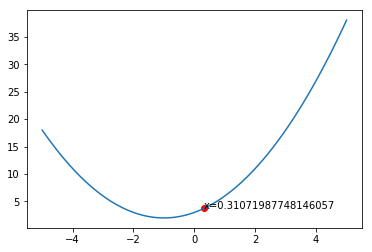

In [0]:
#@title 値の更新とプロット
update(x)
plot(x)

## 勾配法で回帰問題（関数の近似）を解く
何かやりたいこと（機械にやらせたいこと）があった時、
その目的の達成度を滑らかな関数（目的関数またはloss関数）としてうまく表現することができれば、機械学習は実現できる。


ここでは、与えられた各$x$について、正解の二次曲線$y=ax^2+bx+c$と近似する二次曲線$\tilde{y}=\tilde{a}x^2+\tilde{b}x+\tilde{c}$との$y$軸上の二乗距離（$(\tilde{y}-y)^2$）を求め、これらの平均値を目的関数とした。この目的関数を小さくするように近似曲線のパラメータ（$\tilde{a}$,$\tilde{b}$,$\tilde{c}$）を更新して行くことで、二つの近似曲線を正解の二次曲線に近づけることができる。

In [0]:
# 二次関数（パラメータを指定できるようにする）
def func(x, a, b, c):
  return a * x**2 + b * x + c

# xを-5から5までの範囲でランダムに50個与える（サンプリング）
x = tf.random.uniform([50], -5., 5.)

# 正解の関数
a = tf.constant(1.)
b = tf.constant(2.)
c = tf.constant(3.)
y = func(x, a, b, c)

# 近似曲線のパラメータ
_a = tf.get_variable('a', ())
_b = tf.get_variable('b', ())
_c = tf.get_variable('c', ())

# 勾配法で変数を更新
def update(x, y, _a, _b, _c):
  with tf.GradientTape() as g:
    _y = func(x, _a, _b, _c)
    loss = tf.reduce_mean((_y - y)**2) # 目的関数：y軸上の二乗距離の平均
  da, db, dc = g.gradient(loss, [_a, _b, _c]) # 目的関数をパラメータで微分して勾配を求める
  _a.assign_sub(da * 0.002)
  _b.assign_sub(db * 0.002)
  _c.assign_sub(dc * 0.002)

# 正解曲線とその上のサンプル点、さらに近似曲線をプロット
def plot(x, y, a, b, c, _a, _b, _c):
  x_axis = tf.linspace(-5., 5., 100)
  y_axis = func(x_axis, a, b, c)
  _y_axis = func(x_axis, _a, _b, _c)
  plt.plot(x_axis, y_axis)
  plt.plot(x_axis, _y_axis)
  plt.scatter(x, y)
  plt.ylim([tf.reduce_min(y_axis).numpy(), tf.reduce_max(y_axis).numpy()])
  plt.title('$\\tilde{{y}}=({:.2f})x^2+({:.2f})x+({:.2f})$'.format(_a.numpy(), _b.numpy(), _c.numpy()))

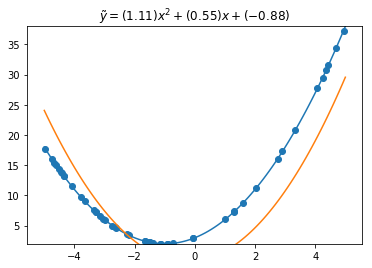

In [0]:
#@title パラメータ更新
update(x, y, _a, _b, _c)
plot(x, y, a, b, c, _a, _b, _c)

## ニューラルネットワーク
- 脳の神経回路を模した学習機械
- ニューロンを模した多入力1出力のユニットを多数つなぎ合わせて、（一般には）多入力多出力の関数を表現する。
- ユニット間の結合重み（これはシナプスを模している）を変更することで、様々な関数を表現できる。
- とにかくたくさんのパラメータを使って多種多様な関数を表現できる。
- 色々な種類のネットワーク構造が提案されていますが、ここでは階層型ニューラルネットワークについて紹介します。

https://ja.wikipedia.org/wiki/ニューラルネットワーク

In [0]:
#@title ニューラルネットワークの構築
#@markdown tf.keras.layersの下に機械学習でよく使う層のクラスが定義されており、また、tf.keras.Modelを使うと、複数の層からなるネットワークの変数の管理が容易になる。

# ニューラルネットワークの層を準備（必要な変数は自動で用意される）
dense1 = tf.keras.layers.Dense(5) # n入力5出力の全結合層（nは前の層に応じて自動で決まる）
relu1 = tf.keras.layers.ReLU() # 0以下の値を全て0にする
dense2 = tf.keras.layers.Dense(5)
relu2 = tf.keras.layers.ReLU()
dense3 = tf.keras.layers.Dense(5)
relu3 = tf.keras.layers.ReLU()
dense4 = tf.keras.layers.Dense(1) # 1出力の最終層

# 1入力、1出力のニューラルネットワーク
x = tf.keras.Input([1])
h1 = relu1(dense1(x))
h2 = relu2(dense2(h1))
h3 = relu3(dense3(h1))
y = dense4(h3)
neural_network = tf.keras.Model(inputs=x, outputs=y)

# xを-1から1までの範囲でランダムに50個与える（サンプリング）
x = tf.random.uniform([50, 1], -1., 1.)

# 正解の関数
def func(x):
  return 1. * x**2 + 2. * x + 3.
y = func(x)

# 勾配法で変数を更新
def update(x, y):
  with tf.GradientTape() as g:
    _y = neural_network(x)
    loss = tf.reduce_mean((_y - y)**2) # 目的関数：y軸上の二乗距離の平均
  variables = neural_network.trainable_variables
  grads = g.gradient(loss, variables) # 目的関数をパラメータで微分して勾配を求める
  for g, v in zip(grads, variables):
    v.assign_sub(g*0.01)

# 正解曲線とその上のサンプル点、さらに近似曲線をプロット
def plot(x, y):
  x_axis = tf.expand_dims(tf.linspace(-1., 1., 100), 1)
  y_axis = func(x_axis)
  _y_axis = neural_network(x_axis)
  plt.plot(x_axis, y_axis)
  plt.plot(x_axis, _y_axis)
  plt.scatter(x, y)
  plt.ylim([tf.reduce_min(y_axis).numpy(), tf.reduce_max(y_axis).numpy()])

In [0]:
#@title 自動で用意された変数
print(dense2.kernel)
print(dense2.bias)

In [0]:
#@title パラメータ更新
for i in range(20):
  update(x, y)
plot(x, y)

## 畳み込みニューラルネットワーク
- 画像に畳み込み（convolution）を施し、得られた特徴マップにさらに畳み込みを施す…といったことを繰り返して複雑な特徴を抽出するニューラルネットワーク。

https://github.com/vdumoulin/conv_arithmetic

In [0]:
conv = tf.keras.layers.Conv2D(2, 3) # 3x3のカーネル二つからなる畳み込み層
relu = tf.keras.layers.ReLU()
x = tf.keras.Input([None, None, 1]) # サイズ未定で1チャンネル（グレースケール）の画像を想定した入力
y = conv(x)
y = relu(y)
model = tf.keras.Model(inputs=x, outputs=y)

# カーネルとバイアスを上書きして結果を見てみる
kernel = [
    [[1., 0., 0.],
     [0., 1., 0.],
     [0., 0., 1.]],

    [[0., 0., 0.],
     [1., 1., 1.],
     [0., 0., 0.]],
]
bias = [
    -1.8,
    -2.
]
conv.kernel = tf.transpose(tf.reshape(kernel, [2,3,3,1]), [1,2,3,0])
conv.bias = tf.constant(bias)

for x, _ in dataset.batch(1).skip(2).take(1):
  y = model(x)
  
channels = tf.shape(y)[3].numpy() # 出力チャネル数
assert channels==2 # カーネルが二つなので2になるはず

for i in range(channels):
  plt.subplot(channels,3,i*3+1)
  plt.imshow(x[0,:,:,0])
  plt.axis('off')
  plt.subplot(channels,3,i*3+2)
  plt.imshow(conv.kernel[:,:,0,i])
  plt.axis('off')
  plt.subplot(channels,3,i*3+3)
  plt.imshow(y[0,:,:,i])
  plt.axis('off')

## 畳み込みニューラルネットワークによる画像の分類

In [0]:
#@title 畳み込みニューラルネットワークによる分類器の構築

conv_layers = []
x = tf.keras.Input([None, None, 1])

# 畳み込みを繰り返し適用
y = x
for i in range(5):
  conv = tf.keras.layers.Conv2D(12, 3, padding='SAME')
  conv_layers.append(conv)
  relu = tf.keras.layers.ReLU()
  y = relu(conv(y))
conv = tf.keras.layers.Conv2D(10, 3, padding='SAME') # 最後のチャネル数はクラス数で
conv_layers.append(conv)
y = conv(y)

# ここまでで画像の各ピクセルには各クラスのスコア
#（Tシャツっぽさ、スニーカーっぽさなど）が表現されている（そうなるようにこれから学習させる！）
# 最後に全ピクセルの平均を取ることで多数決を取る
y = tf.keras.layers.GlobalAveragePooling2D()(y)
# Softmaxを使って各ユニットが確率を表すように正規化する
y = tf.keras.layers.Activation('softmax')(y)
model = tf.keras.Model(inputs=x, outputs=y)

In [0]:
#@title 畳み込みのカーネル
conv = conv_layers[0]

plt.figure(figsize=(15,5))
for i in range(conv.filters):
  plt.subplot(1, conv.filters, i+1)
  plt.imshow(conv.kernel[:,:,0,i], cmap='gray')
  plt.axis('off')

In [0]:
# @title 分類器の学習
# @markdown 実はtf.keras.Modelには、勾配の計算と変数の更新を自動で行う機能が用意されています。ここではこれを使いますが、GANの学習は少し込み入っているため、これが使えません。GANの学習の際は、これまで通り明示的に勾配を求めて変数の更新を行います。

model.compile(tf.train.AdamOptimizer(0.001), loss='categorical_crossentropy')
model.fit(dataset.shuffle(1000).batch(64), epochs=1)

In [0]:
#@title 分類器の出力
n = 10

plt.figure(figsize=(15,5))
for i, (x, y) in enumerate(dataset.shuffle(1000).take(n)):
  plt.subplot(2,n,i+1)
  plt.imshow(x[:,:,0], cmap='gray_r')
  plt.axis('off')
  plt.subplot(2,n,n+i+1)
  plt.plot(model(tf.expand_dims(x, 0))[0].numpy())
  plt.plot(y.numpy())

In [0]:
#@title 中間層の値
sub_model = tf.keras.Model(inputs=model.inputs, outputs=conv_layers[-1].output)

n = 5

label_texts = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

plt.figure(figsize=(15,5))
for x, y in dataset.shuffle(1000).batch(n).take(1):
  hidden = sub_model(x)
  #hidden -= tf.reduce_mean(hidden, -1, keepdims=True)
  hidden = tf.nn.softmax(hidden)
  
for j, text in enumerate(label_texts):
  plt.subplot(n+1,11,j+2)
  plt.text(0,0,text)
  plt.axis('off')
for i in range(n):
  plt.subplot(n+1,11,(i+1)*11+1)
  plt.imshow(x[i,:,:,0], cmap='gray_r')
  plt.axis('off')
  for j in range(10):
    plt.subplot(n+1,11,(i+1)*11+j+2)
    plt.imshow(hidden[i,:,:,j], cmap='Reds' if y[i,j]>0. else 'Blues')
    plt.axis('off')